## Build anndata from `cellatac` output

In this notebook we put together the many outputs of the [cellatac pipeline](https://github.com/cellgeni/cellatac) for peak calling in scATAC-seq data into one handy anndata object, we do some important peak filtering

In [1]:
import numpy as np
import scipy.sparse
import pandas as pd 
import scanpy as sc
import os

In [2]:
import session_info
session_info.show()

In [46]:
outdir = "/nfs/heart/anndata_objects/6region_v2/"
experiment_prefix = '6reg-v2_ATACs'
cellatac_outdir = '/nfs/team205/heart/cellatac/tic-1050/results200k/'

In [5]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

### Make anndata object

In [6]:
%%time
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header = None)
feat = pd.read_table(input["peaks"], header = None)

adata.obs_names = bc[0]
adata.var_names = feat[0]
adata

CPU times: user 22min 15s, sys: 31.9 s, total: 22min 47s
Wall time: 22min 47s


AnnData object with n_obs × n_vars = 110434 × 345189

In [7]:
# check no duplicates in cell_ids
len(adata.obs_names) == len(set(adata.obs_names))

True

### Load peak annotations computed with `annotate_peaks.R`

In [8]:
peak_anno_df = pd.read_csv("/nfs/team205/heart/cellatac/tic-1050/ATACpeaks_annotation.csv", index_col = 0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace = True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)
adata

AnnData object with n_obs × n_vars = 110434 × 345189
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'

In [9]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist
chr1:10051-10384,334,0,0,0,intergenic,NaN,NaN,58706,1
chr1:180688-181608,921,0,0,1,promoter,FO538757.2,ENSG00000279928,784,1
chr1:184068-184538,471,1,1,0,exon,FO538757.2,ENSG00000279928,1674,1
chr1:191295-191619,325,0,1,0,intron,FO538757.1,ENSG00000279457,3791,1
chr1:267873-268085,213,0,0,0,intergenic,NaN,NaN,67550,1


In [10]:
np.max(adata.X.data)

224.0

### Save binary data to layers

In [11]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1 # change to binary
adata

AnnData object with n_obs × n_vars = 110434 × 345189
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

In [12]:
np.max(adata.X.data)

1.0

### Peak filtering

`cellatac` calls a lot of peaks that are just noisy and downsizing the matrix a bit makes everything faster.

#### OBS: Check the filters for your data carefully so you don't throw away usueful info.

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

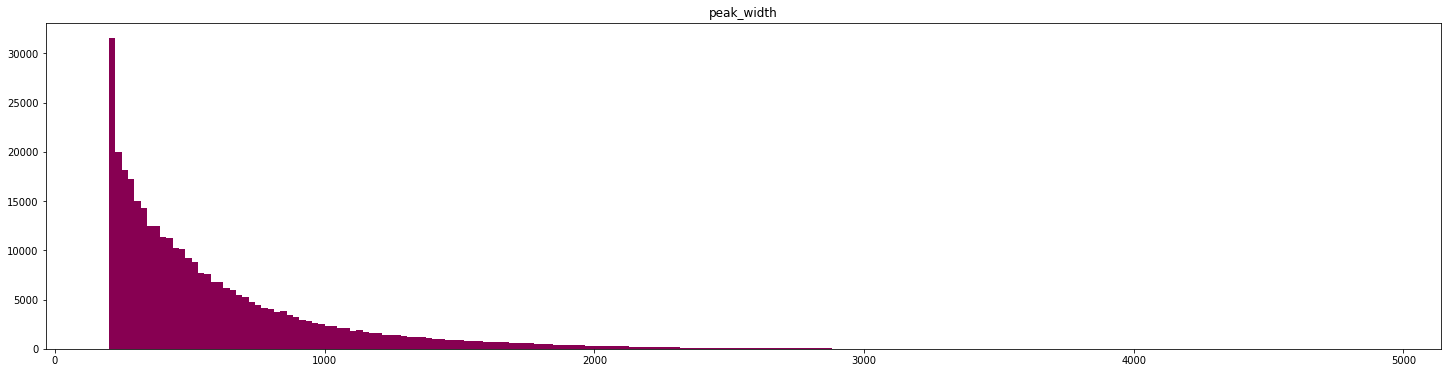

In [13]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [14]:
np.min(adata.var['peak_width'])

201

### Preliminary filtering

- Basic QC

In [15]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1) 
adata

AnnData object with n_obs × n_vars = 110434 × 345189
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [16]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10051-10384,334,0,0,0,intergenic,NaN,NaN,58706,1,679,0.006148,0.006130,99.385153,679.0,6.522093
chr1:180688-181608,921,0,0,1,promoter,FO538757.2,ENSG00000279928,784,1,3403,0.030815,0.030350,96.918521,3403.0,8.132707
chr1:184068-184538,471,1,1,0,exon,FO538757.2,ENSG00000279928,1674,1,661,0.005985,0.005968,99.401452,661.0,6.495265
chr1:191295-191619,325,0,1,0,intron,FO538757.1,ENSG00000279457,3791,1,1350,0.012224,0.012150,98.777550,1350.0,7.208601
chr1:267873-268085,213,0,0,0,intergenic,NaN,NaN,67550,1,591,0.005352,0.005337,99.464839,591.0,6.383507


- Remove cells with peaks accessible in less than k cells

array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

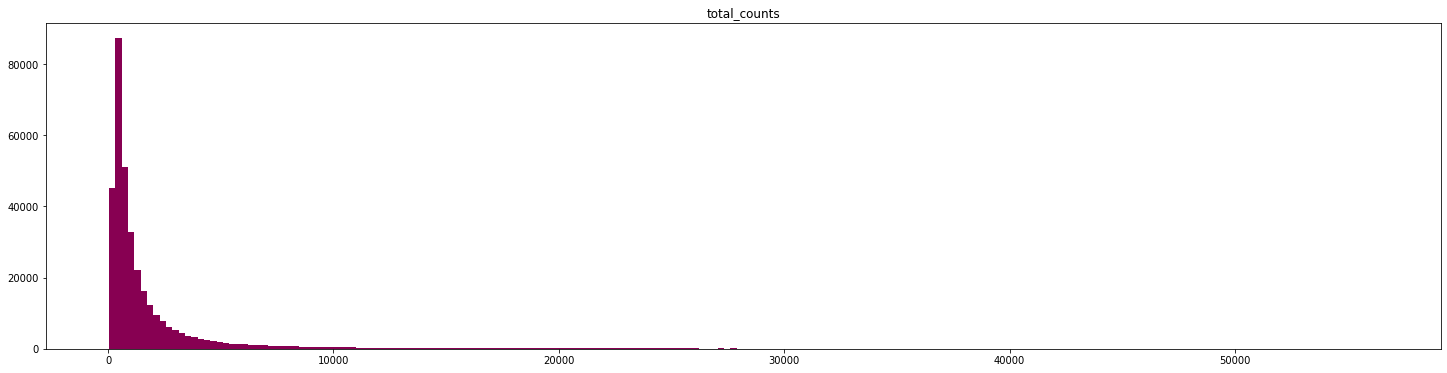

In [17]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')
# total counts in var: total reads (from binary data) per peak 

In [16]:
# make a copy to come back
# adata_prefilter = adata.copy()

In [17]:
# adata = adata_prefilter.copy()

In [18]:
adata = adata[:,adata.var.total_counts > 30]
adata = adata[:,adata.var.total_counts < 6000]
adata

View of AnnData object with n_obs × n_vars = 110434 × 320747
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

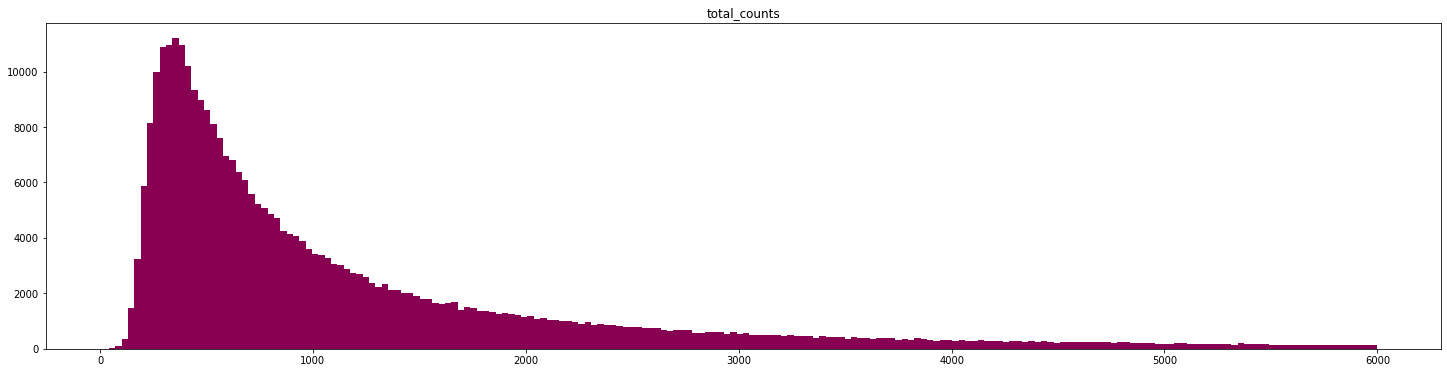

In [19]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

- Remove peaks in ENCODE blacklist

https://www.nature.com/articles/s41598-019-45839-z

In [20]:
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 110434 × 319159
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

In [22]:
adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 110434 × 295063
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

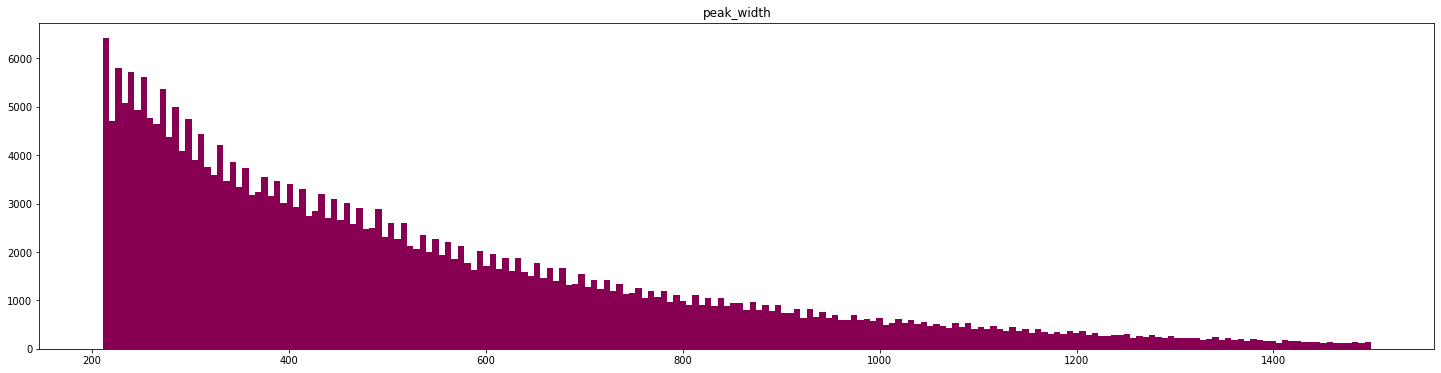

In [23]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

- Filter peaks that are not accessible in at least 10% of cells from a coarse cluster

In [24]:
min_frac = 0.1

- Load cluster information from cellatac outputs

In [25]:
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 110434 × 295063
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Add cluster matrix

In [26]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
print('number of clusters:', n_clusters)
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

number of clusters: 27


/home/jovyan/my-conda-envs/scatac/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jovyan/my-conda-envs/scatac/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [27]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [28]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T  # normalise?

In [29]:
adata = adata[:, cl_peak_frac.max(0) > min_frac]
adata

View of AnnData object with n_obs × n_vars = 110434 × 102627
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

## Add SangerID and other cell metadata

In [37]:
# metadata_snATAC
snATAC=pd.read_csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_snATAC_metadata.csv',index_col=0)
snATAC['dataset']=snATAC['Region']

# metadata_Multiome
Multiome=pd.read_csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_Multiome_metadata.csv')
Multiome['dataset']=''
Multiome.loc[Multiome.query('Donor==3').index,'dataset']='Multiome_1'
Multiome.loc[Multiome.query('Donor==7').index,'dataset']='Multiome_1'
Multiome.loc[Multiome.query('Donor==8').index,'dataset']='Multiome_2'
Multiome['Donor']=['D'+str(x) for x in Multiome['Donor']]

# cellatac_code to sangerID
cellmeta_tagmap = pd.read_table(cellatac_outdir+'cellmetadata/tagmap.txt', header=None)
cellmeta_tagmap['cellatac_code']=[x.split('-')[0] for x in cellmeta_tagmap[0]]
cellmeta_tagmap['sangerID']=[x.split('-')[0] for x in cellmeta_tagmap[1]]
code2ID2meta = cellmeta_tagmap[['cellatac_code','sangerID']]
code2ID2meta.drop_duplicates(inplace=True)

# cellatac_code to sangerID to metadata
ID2meta=pd.concat([snATAC[['SangerID','dataset','Donor','Region']],Multiome[['SangerID','dataset','Donor','Region']]],axis=0)
code2ID2meta = code2ID2meta.merge(ID2meta, how='left', left_on='sangerID', right_on='SangerID')
code2ID2meta.drop(['SangerID'], axis=1, inplace=True)
code2ID2meta.head()

<ipython-input-37-9bc5cc5ff148>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code2ID2meta.drop_duplicates(inplace=True)


,cellatac_code,sangerID,dataset,Donor,Region
0,01,HCAHeart8374324,LV,D5,LV
1,02,HCAHeart8374325,RV,D6,RV
2,03,HCAHeart8374326,LA,D7,LA
3,04,HCAHeart8374327,LA,D5,LA
4,05,HCAHeart8374328,LV,D6,LV


In [38]:
# adding sample info to adata.obs (regions for snATAC and Multiome-t1 and t2)
adata.obs['cellatac_code']=[x.split('-')[0] for x in adata.obs.index]

index=adata.obs_names
adata.obs=adata.obs.merge(code2ID2meta, how='left', on='cellatac_code')
adata.obs.set_index(index, inplace=True)

adata.obs['dataset']=adata.obs['dataset'].astype('category')
adata.obs['dataset'].cat.reorder_categories(['RA','LA','RV','LV','SP','AX','Multiome_1','Multiome_2'], inplace=True)

adata.obs['Region']=adata.obs['Region'].astype('category')
adata.obs['Region'].cat.reorder_categories(['RA','LA','RV','LV','SP','AX'], inplace=True)

Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/scatac/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [39]:
adata

AnnData object with n_obs × n_vars = 110434 × 102627
    obs: 'cellatac_clusters', 'cellatac_code', 'sangerID', 'dataset', 'Donor', 'Region'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Filter low quality nuclei

In [40]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

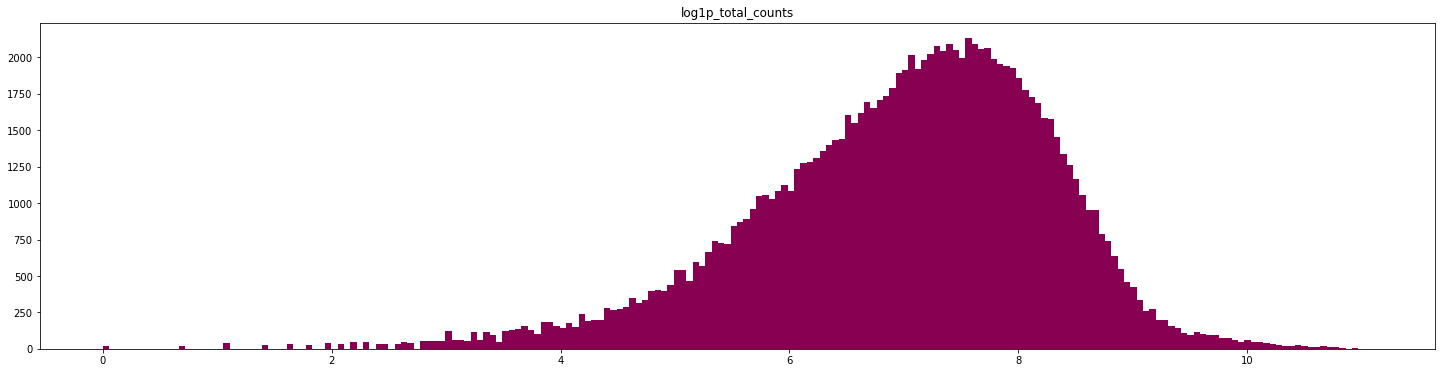

In [41]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

**filtering based on Signac-QC (No2 and No3)**

In [42]:
# Read in qualified cell barcode 
Multiome_QCed=pd.read_table('/nfs/team205/kk18/data/mapped/cellranger-arc101/6reg-v2_MultiomeATAC_Signac-QCed-barcodes.txt', header=None)
snATAC_QCed=pd.read_table('/nfs/team205/kk18/data/mapped/cellranger-atac120/6reg-v2_snATAC_Signac-QCed-barcodes.txt', header=None)
QCed = pd.concat([Multiome_QCed, snATAC_QCed])
QCed

,0
0,HCAHeart9508819_AAACATGCAGCAGGTA-1
1,HCAHeart9508819_AAACATGCATAGCTGC-1
2,HCAHeart9508819_AAACCAACAAGGTGCA-1
3,HCAHeart9508819_AAACCAACACTTAACG-1
4,HCAHeart9508819_AAACCAACAGCCGCTA-1
...,...
48093,HCAHeart8374344_TTTGGTTTCATTGCCC-1
48094,HCAHeart8374344_TTTGGTTTCGTTACAG-1
48095,HCAHeart8374344_TTTGTGTAGTACAACA-1
48096,HCAHeart8374344_TTTGTGTCACTGTCGG-1


In [43]:
# Concatenate sample ID and barcodes 
adata.obs['sangerID']=adata.obs['sangerID'].astype('str')
adata.obs['barcode'] = [x[3:] for x in adata.obs_names]
adata.obs['fullbarcode']=adata.obs['sangerID']+'_'+adata.obs['barcode']
adata.obs['oribarcode'] = adata.obs_names 
adata.obs.set_index('fullbarcode', inplace=True)
adata.obs.head()

,cellatac_clusters,cellatac_code,sangerID,dataset,Donor,Region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,barcode,oribarcode
fullbarcode,,,,,,,,,,,,,,,,
HCAHeart8374324_AAACGAATCAAACCCA-1,26,01,HCAHeart8374324,LV,D5,LV,14330,9.570180,14330.0,9.570180,0.348918,0.697837,1.395673,3.489184,AAACGAATCAAACCCA-1,01-AAACGAATCAAACCCA-1
HCAHeart8374324_AAACTGCAGACCCTAT-1,9,01,HCAHeart8374324,LV,D5,LV,54,4.007333,54.0,4.007333,92.592593,100.000000,100.000000,100.000000,AAACTGCAGACCCTAT-1,01-AAACTGCAGACCCTAT-1
HCAHeart8374324_AAAGGATAGGCACTAG-1,9,01,HCAHeart8374324,LV,D5,LV,6498,8.779404,6498.0,8.779404,0.769468,1.538935,3.077870,7.694675,AAAGGATAGGCACTAG-1,01-AAAGGATAGGCACTAG-1
HCAHeart8374324_AAAGGGCAGCGAGCTA-1,8,01,HCAHeart8374324,LV,D5,LV,11800,9.375940,11800.0,9.375939,0.423729,0.847458,1.694915,4.237288,AAAGGGCAGCGAGCTA-1,01-AAAGGGCAGCGAGCTA-1
HCAHeart8374324_AAAGGGCAGTGATATG-1,16,01,HCAHeart8374324,LV,D5,LV,2999,8.006368,2999.0,8.006368,1.667222,3.334445,6.668890,16.672224,AAAGGGCAGTGATATG-1,01-AAAGGGCAGTGATATG-1


In [44]:
# Do filtering
adata=adata[adata.obs.index.isin(QCed[0])]
adata

View of AnnData object with n_obs × n_vars = 79208 × 102627
    obs: 'cellatac_clusters', 'cellatac_code', 'sangerID', 'dataset', 'Donor', 'Region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'barcode', 'oribarcode'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

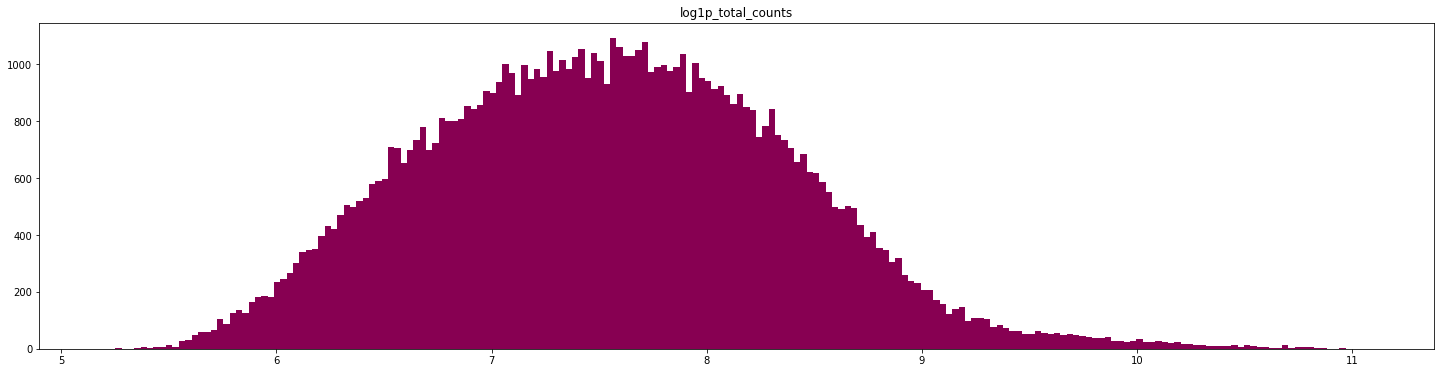

In [45]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

### Write output anndata

In [47]:
# adata.write(output["h5ad"])
adata.write(outdir + experiment_prefix + '_filtered.h5ad')

/home/jovyan/my-conda-envs/scatac/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cellatac_code' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sangerID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'barcode' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


In [48]:
adata.obs['dataset'].value_counts()

Multiome_1    19099
Multiome_2    12011
LV             9109
AX             8809
SP             8123
RA             7569
LA             7282
RV             7206
Name: dataset, dtype: int64

In [49]:
adata.obs['Region'].value_counts()

LV    22906
RA    17313
SP    11919
LA    10352
AX     9208
RV     7510
Name: Region, dtype: int64